In [1]:
#### import random
from matplotlib import pyplot as plt
import random
import numpy as np
import pandas as pd
from scipy.ndimage.interpolation import shift
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statistics import mean

from scipy import stats
import math

# plt.rcParams["figure.figsize"] = (20,10)
# plt.rcParams.update({'font.size': 22})

In [24]:
class Agent():
    '''
    The class defines the main characteristics of my agents
    They have some money and assets
    '''
    def __init__(self, money, confidence, model):
        self.money = 0
        
        if random.random () <0.4:
            self.confidence = random.random()*0.5 + 0.5
        else:
            self.confidence = random.random()
        
        self.asset = model.produce
        self.num_of_assets_owned = 0
        
        self.agent_keep_asset = list()
        self.num_of_keep = 0
        
        self.agent_buy_asset = list()
        self.num_of_buy = 0 
        
        self.agent_sell_asset = list()
        self.num_of_sell = 0
        
        self.error = stats.norm.rvs(loc = 0, scale = 5)
        

        '''
        Here I'm assigning agents to a Expectation Formation type randomly
        To keep things simple for now, agents will use the same decisions-making technique
        '''

        if random.random() <0.4:
            self.EP_type = 0 #1 - Agents with limited knowledge and predictive capabilities
        else:
            self.EP_type = 1 #0 - Agents with limited knowledge but better predictive capabilities
           
        
        '''
        Keeping track of all transactions agents make every time step
        '''
        self.transaction_history = list()
        if self.keep_asset:
            self.decision_keep = 1

        if self.sell_asset:
            self.decision_sell = 1
        
        if self.buy_asset:
            self.decision_buy = 1

        
        self.time = 0

        self.model = model

        '''
        Keeping track of predicted price.
        '''
        self.time_history = list()
        self.predict_price = 0
        self.AR_predictions = []
        self.LR_predictions = list()
        
        
        
    def step(self):
        '''
        Two things happening every timestep:
        1) Agents will earn money
        2) Asset will step forward in time also
        3) Agents will fall into either 2 types of decision-making behaviours, simple linear regression or autoregression
        '''
        self.earn_money(20)
        
        
        self.time += 1
        
        '''
        If the agent falls into the limited knowledge and predictive capabilities type, 
        they use a simple linear regression to predict the next asset price
        '''

        if self.EP_type == 0:
            self.predict_AR()
            self.AR_decision()
        
        else:
            self.predict_regession()
            self.reg_decision()
            
        
        self.change()
        
        agent_sell_asset = list()       
        if self.transaction_history == 'sell':
            agent_sell_asset.append(agent)
        self.num_of_sell = len(self.agent_sell_asset)
        self.agent_sell_asset.append(self.num_of_sell)
        
        agent_buy_asset = list()       
        if self.transaction_history == 'buy':
            agent_buy_asset.append(agent)
        self.num_of_buy = len(self.agent_buy_asset)
        self.agent_buy_asset.append(self.num_of_buy)
        
        agent_keep_asset = list()       
        if self.transaction_history == 'keep':
            agent_keep_asset.append(agent)
        self.num_of_keep = len(self.agent_keep_asset)
        self.agent_keep_asset.append(self.num_of_keep)
        
        self.time_history.append(self.time)
        

            
        '''
        Then, if the predicted price equal actual asset price then they keep the asset, 
        if predicted price is less actual asset price they sell, 
        and if the predicted price is greater than asset price they sell
        '''
            
    
    def earn_money(self, amount):
        '''
        To introduce a possility of not earning disposable income every timestep, I included a probability
        '''
        if random.random( ) <0.2:
            self.money += amount
        
            
    def predict_regession(self):
        '''
        Expectation formation behaviour type 1:
        Simple linear regession predict the asset price considering previous asset prices. 
        Following each timestep, actual asset prices are added to the price history. 
        '''        
        y=self.asset.price_history.reshape(-1, 1)
        X=self.asset.time_history.reshape(-1, 1)
        #print(y, X, y.shape, X.shape)
        reg=LinearRegression().fit(X,y)
        next_time = np.zeros((1, 1))
        next_time[0][0] = model.time + 1
        
        # Predict price for next timestep
        self.predict_price = reg.predict(next_time)

        # Add some random noise in about 50% of the cases
        if random.random() > 0.5:
            self.predict_price += self.error
        
        # Add the prediction to the list
        self.LR_predictions.append(self.predict_price[-1, -1])


    def predict_AR(self):
        '''
        Expectation formation behaviour type 2:
        Autoregessive predictor
        '''
        y1=self.asset.price_history
        log_x = np.log(y1)
        log_x_shift = shift(log_x, 1, cval=0)
        log_of_x = log_x - log_x_shift

        decomposition = seasonal_decompose(log_x, period= 1) 
        model = ARIMA(log_x, order=(2,1,0))
        results = model.fit(disp=-1)
#         plt.plot(log_x_shift)
#         plt.plot(results.fittedvalues, color='red')
           
        predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
        predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
        predictions_ARIMA_log = pd.Series(log_x)
        predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
        predictions_ARIMA = np.exp(predictions_ARIMA_log)
#         plt.plot(df)
#         plt.plot(predictions_ARIMA)
        self.predict_price = predictions_ARIMA.iloc[0]
        
#         results.plot_predict(1,50)
#         plt.plot(y1, color = 'blue', label = 'Original')
#         plt.plot(predictions_ARIMA, color = 'green', label = 'Predictions')
#         plt.legend(loc = 'best')
#         plt.title('ARIMA Forecast')
#         plt.xlabel("Iteration (time)")
#         plt.ylabel("Market Prices")
#         plt.savefig('ARIMA_predictions.png')
#         plt.show()
    
        
        if random.random()> 0.5:
            self.predict_price += self.error

        self.AR_predictions.append(self.predict_price)
        

            
    def AR_decision(self):
        if (self.predict_price > self.asset.update_price) and (self.money > self.asset.update_price):
            self.buy_asset()
            self.transaction_history.append('buy')
        elif self.predict_price  == self.asset.update_price:
            self.keep_asset()
            self.transaction_history.append('keep')
        elif self.predict_price  < self.asset.update_price:
            self.sell_asset()
            self.transaction_history.append('sell')
            
        print('My Autoregressive Price Prediction = {0}, Decision = {1}, My Money = {2}'.format(self.predict_price, self.transaction_history, self.money))
          
    def reg_decision(self):
        if self.confidence > 0.2:
            if (self.predict_price[0][0] > self.asset.update_price) and (self.money > self.asset.update_price):
                self.buy_asset()
                self.transaction_history.append('buy')
                
            elif self.predict_price[0][0] == self.asset.update_price:
                self.keep_asset()
                self.transaction_history.append('keep')

            elif (self.predict_price[0][0] < self.asset.update_price) and self.num_of_assets_owned > 1 :
                self.sell_asset()
                self.transaction_history.append('sell')
            print('My Regressions Price Prediction = {0}, Decision = {1}, My Money = {2},  My confidence = {3}'.format(self.predict_price, self.transaction_history, self.money,  self.confidence))
        else:
            if self.keep_asset:
                if self.num_of_sell > model.population/1.5:
                    self.sell_asset()
                    self.transaction_history.append('sell')
                    print('I feel forced to sell')
                elif self.num_of_buy > model.population/1.5: 
                    self.buy_asset()
                    self.transaction_history.append('buy')
                    print('I feel forced to buy')
            print('My Regressions Price Prediction = {0}, Decision = {1}, My Money = {2},  My confidence = {3}'.format(self.predict_price, self.transaction_history, self.money,  self.confidence))

            
    
    def change(self):
        #calculating the difference between each predictor and actual market price 
        
        diff_lr = 0 
        
        if self.EP_type == 1:
            for agent in self.model.agents:
                diff_lr = self.predict_price - self.asset.price_history[0]
                print(diff_lr)
            else:
                pass
        
        # the predictor that produces the most accurate results should have the smallest difference
        # so agents move to the better predictor 
        
        if self.EP_type == 1:
            if self.model.diff_ar < diff_lr:
                self.EP_type == 1
                print('I am changing to AR because SLR is the worse predictor')
            else:
                print('I am not changing my predictor')
        
    
    def keep_asset(self):
        self.num_of_assets_owned += 0 
        self.money += 0
    
    def sell_asset(self):
        self.num_of_assets_owned -= 1 
        self.money += self.asset.price
    
    def buy_asset(self):
        self.num_of_assets_owned += 1
        self.money -= self.asset.price
    
        

In [25]:
class Asset():
    
    def __init__(self):
        '''
        Contains, asset price, a time log and their histories. 
        backdated prices that are randomly generated for a previous time periods.
        '''
        self.price = 50
        self.time = 1
        self.backdated = (50, 49, 51, 53, 50 ,47 ,55, 48 ,53, 55, 49, 52, 42, 51, 54, 44, 40, 55, 54, 49, 49, 51, 53, 50 ,47 ,55) 
        
              
        for i in range(len(self.backdated)):
            self.price_history = list(self.backdated)
        
        self.price_history = np.array(self.price_history)
        self.price_history = self.price_history.reshape(-1, 1)
        
      
        self.backdated_time= (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25)
        for i in range(len(self.backdated_time)):
            self.time_history = list(self.backdated_time)
        
        self.time_history = np.array(self.time_history)
        self.time_history = self.time_history.reshape(-1, 1)
        
        
    def step(self):
        '''
        Every time step, the price will update, keeping a log of time.
        '''
        self.update_price = stats.norm.rvs(loc = 47, scale = 5)
        self.time += 1
        
#         self.price_history.append(self.price)
        self.price_history= np.append(self.update_price, self.price_history, self.price)


#         self.time_history.append(self.time)
        self.time_history = np.append(self.time_history, self.time)
#         plt.plot(self.time_history)
        

In [26]:
class Model():
    '''
    This class includes functions suchas popuation, model iterations, and a step and run function
    '''
    def __init__(self, population, num_iterations):
        self.population = population
        
        '''
        Renaming the Asset, 'Produce' and associate my agents to it. 
        '''
        self.produce = Asset()
        self.agents = [Agent(0, 0, self) for i in range (self.population)]
        
        
        self.AR_aveg = 0 
        self.diff_ar = 0



        self.num_iterations = num_iterations
        
        '''
        Recording time
        '''
        self.time = 0
        
    def step(self):
        '''
        Steps model forwards
        '''
        # Step Asset price
        self.produce.step()
        print('Market Price:{}'.format( self.produce.update_price))


        # Step agents 
        for i, agent in enumerate(self.agents):
            print('Agent: {0}/{1}'.format(i, self.population))
            agent.step()
            
        # Step time
        self.time += 1
        
        self.AR_aveg = mean([a.predict_price for a in self.agents if a.EP_type == 0]) 
        print('ARIMA average: {}'.format(self.AR_aveg))
        
        self.diff_ar = self.AR_aveg -  self.produce.price_history[0]
        print('ARIMA difference: {}'.format(self.diff_ar))
        
    
  
    def run(self):
        '''
        For every time period, and for every agent in my list of agents, run the step function
        '''
        for t in range(self.num_iterations):
            print('Timestep: {}'.format(self.time))
            self.step()
        
#         for agent in self.agents:
#             print(agent.time_history, agent.AR_predictions, agent.LR_predictions)

In [27]:
# if __name__ == "__main__":
model = Model(population =3, num_iterations=25)
model.run()

Timestep: 0
Market Price:42.467224734715224
Agent: 0/3
My Regressions Price Prediction = [[50.10215099]], Decision = [], My Money = 0,  My confidence = 0.35709608415546457
[[7.63492626]]
[[7.63492626]]
[[7.63492626]]
I am changing to AR because SLR is the worse predictor
Agent: 1/3
My Autoregressive Price Prediction = 54.06994803332667, Decision = [], My Money = 0
Agent: 2/3
My Autoregressive Price Prediction = 42.18256430742183, Decision = ['sell'], My Money = 50
ARIMA average: 48.12625617037425
ARIMA difference: 5.659031435659024
Timestep: 1
Market Price:50.899352292626396
Agent: 0/3
My Regressions Price Prediction = [[50.185285]], Decision = [], My Money = 0,  My confidence = 0.35709608415546457
[[-0.71406729]]
[[-0.71406729]]
[[-0.71406729]]
I am not changing my predictor
Agent: 1/3
My Autoregressive Price Prediction = 62.43644433545158, Decision = [], My Money = 0
Agent: 2/3
My Autoregressive Price Prediction = 50.549060609546736, Decision = ['sell', 'sell'], My Money = 100
ARIMA 

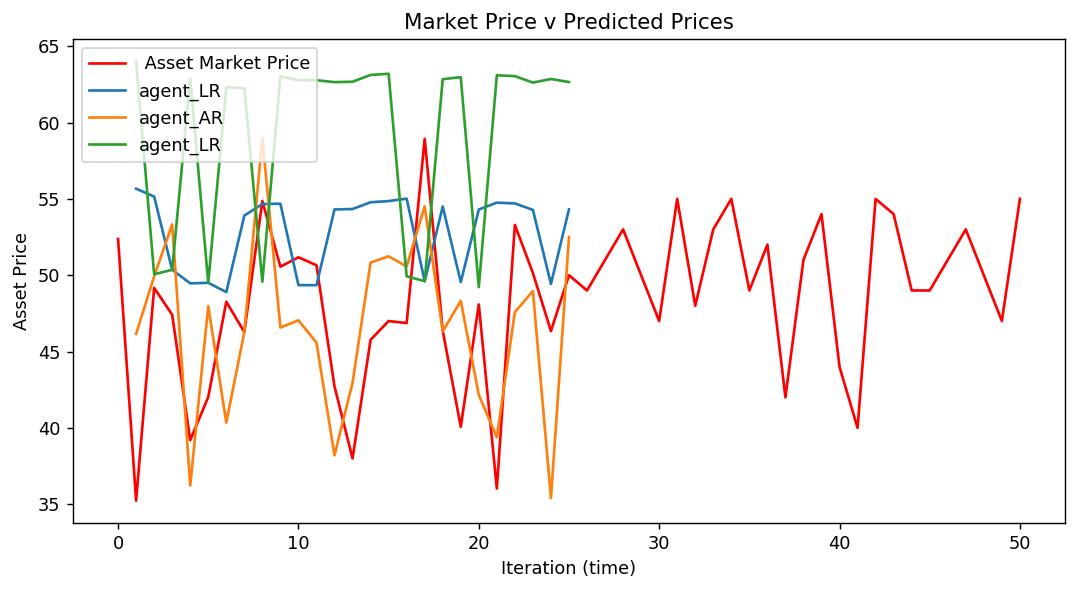

In [21]:
fig, ax = plt.subplots(num=None, figsize=(10, 5), dpi=128, facecolor='w', edgecolor='k')
        # Do a scatter plot
ax.plot(model.produce.price_history, c="red", label=" Asset Market Price" ) 
for agent in model.agents:
    if agent.EP_type == 0:
        ax.plot(agent.time_history, agent.AR_predictions, label='agent_AR')
    elif agent.EP_type == 1:
        ax.plot(agent.time_history, agent.LR_predictions, label='agent_LR')
ax.set_title("Market Price v Predicted Prices")
ax.set_xlabel("Iteration (time)")
ax.set_ylabel("Asset Price")
ax.legend(loc='upper left')
plt.savefig('Comparison.png')